# Robot Policies

A robot policy is the decision-making core of a robot - a model that takes in observations (images, sensor data, motor states) from the world and outputs actions (motor control) to take. Most dominant type of policies today are referred to as Vision-Language-Action (VLA) models.

In this notebook we will learn how robot policies work. Then we will explore the structure of common VLA datasets. Finally, we'll run SmolVLA - a popular foundation model from Hugging Face - on your Ryzen AI machine.

## Goals

* Learn about robot policies and VLAs
* Dissect a VLA training dataset
* Run a SmolVLA, a tiny 500M model, and inspect outputs

## References

* [SO-101 Pick and Place Dataset](https://huggingface.co/datasets/lerobot/svla_so101_pickplace)
* [SmolVLA](https://huggingface.co/blog/smolvla)

## Vision-Language-Action models

VLAs are the new frontier of robot learning. In addition to vision and text, they incorporate a native action modality, allowing the model to be trained end-to-end from prompt to motor actions.

These models are typically a combination of a VLM, like we've seen before, and a custom action expert that cross-attends to the features extracted by the VLM backbone to control the robot.

## Exploring a VLA Dataset

We will start by downloading one of the datasets from HuggingFace and walk through the structure and contents. By doing this we will build intuition on robot policy learning and what these models expect as inputs. Most of this will be applicable to the majority of robot policies, however VLAs are unique in that they are conditioned on text instructions in addition to images and motor joint states.

### Load the Dataset

Let's load one of the official LeRobot datasets. Many datasets like this exist on the Hugging Face hub, along with models. This particular dataset is for training SmolVLA to perform pick-and-place tasks with an [SO-101](https://github.com/TheRobotStudio/SO-ARM100) arm (a low-budget 3D printed arm from the Robot Studio).

In [1]:
import matplotlib.pyplot as plt
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset

# Load the dataset
dataset = LeRobotDataset("lerobot/svla_so101_pickplace", video_backend="pyav")

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

In [2]:
dataset

LeRobotDataset({
    Repository ID: 'lerobot/svla_so101_pickplace',
    Number of selected episodes: '50',
    Number of selected samples: '11939',
    Features: '['action', 'observation.state', 'observation.images.up', 'observation.images.side', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index']',
})',

What do we get in a dataset?

**Useful metadata:**
* **Number of episodes** - only 50, a typical number for finetuning a foundation model (you wouldn't use this to train a VLA from scratch).
* **Total number of samples** across all 50 episodes, giving us ~200-300 video frames and motor joint positions per episode.

**Features (core training data):**
* **Action** - next action to be performed given current observation (labels)
* **Observation.\*** - items under this umbrella include the motor states and images that we'll train on (inputs)
* **Task** - the text instruction of what the model is supposed to do.
* **Other metadata** - timestamps, indexes of each frame, etc.

### What is the Task?

Before anything else lets print out the task so we know what the model is supposed to do.

In [3]:
dataset[0]['task']

'pink lego brick into the transparent box'

### Visualize Observations

We'll start by grabbing the first sample of the dataset and visualizing the two images. This is the inputs at one time frame coming from two cameras observing the robot arm. Generally the more cameras the better because it boosts the models spatial reasoning and helps deal with occlusions.

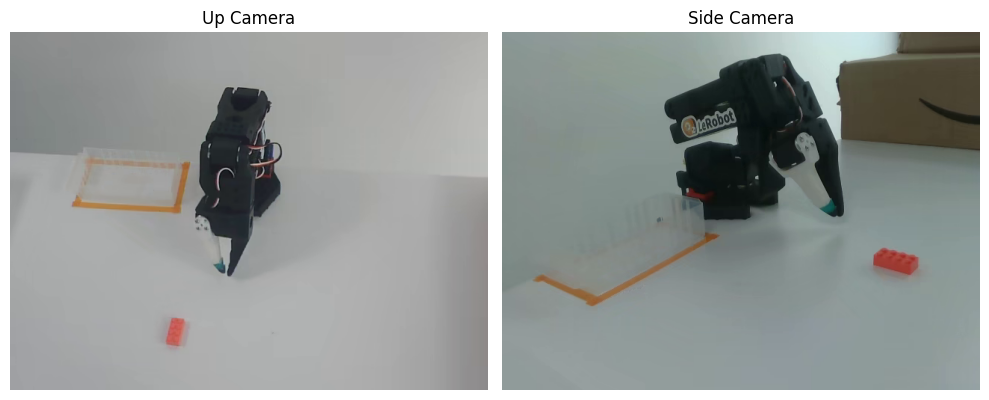

In [4]:
# Up camera
img_up = dataset[0]['observation.images.up'].numpy()
image_up = img_up.transpose(1, 2, 0)

# Side camera
img_side = dataset[0]['observation.images.side'].numpy()
image_side = img_side.transpose(1, 2, 0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_up)
axes[0].set_title("Up Camera")
axes[0].axis("off")

axes[1].imshow(image_side)
axes[1].set_title("Side Camera")
axes[1].axis("off")

plt.tight_layout()
plt.show()

### Visualize Motor States

In addition to visual stimulus a needs to know its current position - this is proprioception data. Proprioception is simply the current joint positions read out from each motor of the arm. The SO-101 has **6 joints:**
* shoulder_pan
* shoulder_lift
* elbow_flex
* wrist_flex
* wrist_roll
* gripper

LeRobot datasets usually normalize the angles these corresponding motors can turn to [-100, 100]. This corresponds to the limits of how far the joints can extend during calibration (not necessarily +180°/-180°). For example, the gripper of the SO-101 is composed of 2 jaws, but only one of them is controlled by a motor. Since it physically can't push through the non-moving jaw it can only roughly rotate 0-90°, and gets normalized to [0,100] (basically how open or closed it is).

This is the initial state of the robot arm at the start of the episode:

In [5]:
dataset[0]['observation.state']

tensor([  1.9561, -98.7437,  98.9242,  74.8198, -51.4530,   1.4094])

The entire episode (~300 frames) includes the motor positons of the arm during each sample - these trajectories is what the robot policy is being to reproduce. Let's plot how the motor states change throughout the episode.

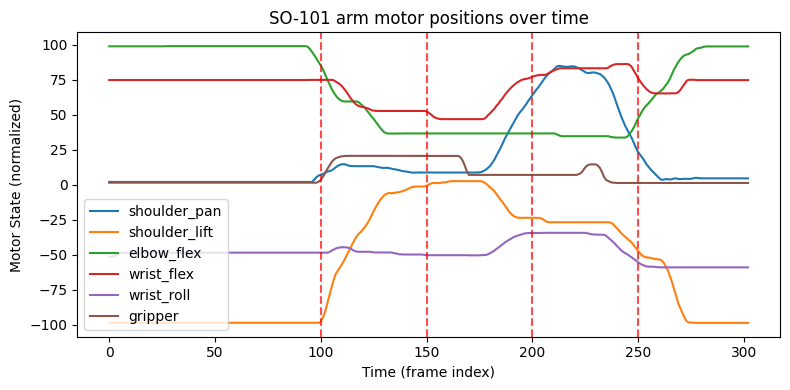

In [6]:
import matplotlib.pyplot as plt
import numpy as np

states = []
episode_idx = dataset[0]["episode_index"]  # first episode index

for sample in dataset:
    if sample["episode_index"] != episode_idx:
        break
    states.append(sample["observation.state"])

states = np.array(states)  # shape: [T, 6]

motor_labels = ["shoulder_pan", "shoulder_lift", "elbow_flex", "wrist_flex", "wrist_roll", "gripper"]
indices = [100, 150, 200, 250]

plt.figure(figsize=(8, 4))
plt.plot(states)
plt.title("SO-101 arm motor positions over time")
plt.xlabel("Time (frame index)")
plt.ylabel("Motor State (normalized)")
plt.legend(motor_labels, loc="lower left")

# Add vertical lines
for idx in indices:
    plt.axvline(x=idx, color="red", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

Along with joint positions lets see what the arm actually looks like during these time steps. If we focus our attention of the gripper we can infer what's happening along with the images below

- **Samples 100-150** - we see gripper go from resting position to opening - it's getting ready to grab the cube
- **Samples 150-200** - now the gripper closes again, but not back to its initial grip because it's holding something in its jaws
- **Samples 200-250** - there's a brief spike where it opens up again - this is the arm releasing the cube into the transparent container
- **Samples 250-300** - gripper goes back to resting closed position

You can do a similar exercise, just visually following a different joint. For example it's pretty obvious what the shoulder is doing - it needs to elevate the arm so it can move towards the cube.

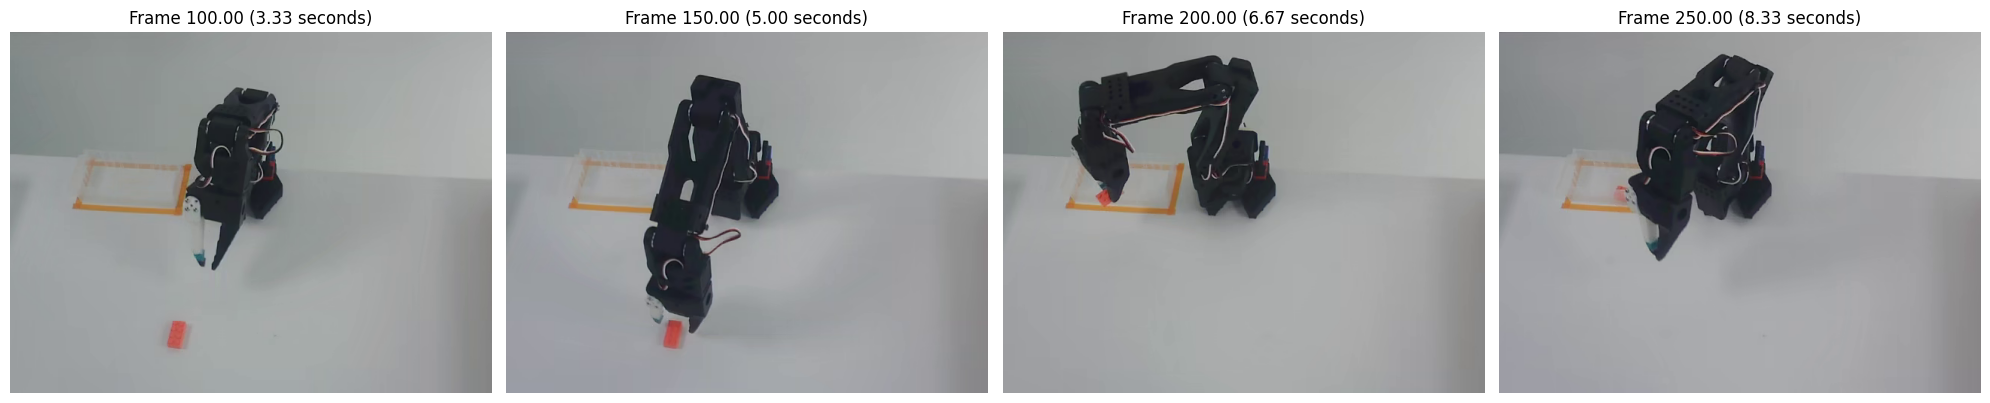

In [7]:
# Draw images at indicated indices
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, idx in zip(axes, indices):
    sample = dataset[idx]  # one sample from the episode
    img_side = sample["observation.images.up"].numpy()  # shape: C,H,W
    img_side = img_side.transpose(1, 2, 0)  # CHW → HWC

    ax.imshow(img_side)
    ax.set_title(f"Frame {sample['frame_index']:.2f} ({sample['timestamp']:.2f} seconds)")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Running SmolVLA

Let's load and run the SmolVLA model to see how VLA inference works.

### Run on Random Samples

As a pipecleaner exercise it's useful to just run the model on some random samples.

**Note** if you are running this on a cloud instance you might see the CPU be used instead of GPU. This is normal. The same code will run on your iGPU on a local machine.

In [8]:
import torch
import time
from lerobot.common.policies.smolvla.modeling_smolvla import SmolVLAPolicy
from lerobot.common.policies.smolvla.configuration_smolvla import SmolVLAConfig
from transformers import AutoProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"

policy = SmolVLAPolicy.from_pretrained("lerobot/smolvla_base",revision="3326b10").to(device)
policy.eval();

# Dummy batch config for a single observation
batch_size = 1
img_shape = (3, 512, 512)  # (C, H, W)
# Infer state_dim from the loaded normalization stats
state_dim = policy.normalize_inputs.buffer_observation_state.mean.shape[-1]

dummy_batch = {
    # a single image observation
    "observation.image": torch.rand(batch_size, *img_shape).to(device),
    # a single state observation
    "observation.state": torch.rand(batch_size, state_dim).to(device),
    "task": ["stack the blocks"] * batch_size,
}

# --- Prepare inputs for the model ---
images, img_masks = policy.prepare_images(dummy_batch)
state = policy.prepare_state(dummy_batch)
lang_tokens, lang_masks = policy.prepare_language(dummy_batch)

with torch.no_grad():
    output = policy.model.sample_actions(images, img_masks, lang_tokens, lang_masks, state)

print(f"Output actions shape: {output.shape}")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading  HuggingFaceTB/SmolVLM2-500M-Video-Instruct weights ...
Reducing the number of VLM layers to 16 ...
[standardise_state_dict] 'normalize_inputs.buffer_observation_state.mean'  ←  ['normalize_inputs.so100-red_buffer_observation_state.mean', 'normalize_inputs.so100_buffer_observation_state.mean']
[standardise_state_dict] 'normalize_inputs.buffer_observation_state.std'  ←  ['normalize_inputs.so100-red_buffer_observation_state.std', 'normalize_inputs.so100_buffer_observation_state.std']
[standardise_state_dict] 'normalize_targets.buffer_action.mean'  ←  ['normalize_targets.so100-red_buffer_action.mean', 'normalize_targets.so100_buffer_action.mean']
[standardise_state_dict] 'normalize_targets.buffer_action.std'  ←  ['normalize_targets.so100-red_buffer_action.std', 'normalize_targets.so100_buffer_action.std']
[standardise_state_dict] 'unnormalize_outputs.buffer_action.mean'  ←  ['unnormalize_outputs.so100-red_buffer_action.mean', 'unnormalize_outputs.so100_buffer_action.mean']
[standa

/opt/venv/lib/python3.12/site-packages/transformers/integrations/sdpa_attention.py:96: UserWarning: Using AOTriton backend for Efficient Attention forward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/attention.hip:1180.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Output actions shape: torch.Size([1, 50, 32])


### Running on Dataset Sample

Now we can format a single dataset sample to generate an action chunk (50 actions in one inference) based on the image inputs and instructions. Since the dataset is primarily used for training it's not setup by default to be ingested by the SmolVLA policy. This means we'll have to generate a new dict from the dataset sample.

In [9]:
import torch
from lerobot.common.policies.smolvla.modeling_smolvla import SmolVLAPolicy
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from utils import sanitize_norm

device = "cuda" if torch.cuda.is_available() else "cpu"

policy = SmolVLAPolicy.from_pretrained("lerobot/smolvla_base", revision="3326b10").to(device).eval()
sanitize_norm(policy)

sample = dataset[0]

nb = policy.normalize_inputs({
    "observation.image":  sample["observation.images.up"].unsqueeze(0).to(device),
    "observation.image2": sample["observation.images.side"].unsqueeze(0).to(device),
    "observation.state":  sample["observation.state"].unsqueeze(0).to(device),
    "task":               [sample["task"]],
})

with torch.no_grad():
    images, img_masks = policy.prepare_images(nb)
    state             = policy.prepare_state(nb)
    lang_tokens, lang_masks = policy.prepare_language(nb)
    actions = policy.model.sample_actions(images, img_masks, lang_tokens, lang_masks, state)

print(actions.shape, actions[0])

Loading  HuggingFaceTB/SmolVLM2-500M-Video-Instruct weights ...
Reducing the number of VLM layers to 16 ...
[standardise_state_dict] 'normalize_inputs.buffer_observation_state.mean'  ←  ['normalize_inputs.so100-red_buffer_observation_state.mean', 'normalize_inputs.so100_buffer_observation_state.mean']
[standardise_state_dict] 'normalize_inputs.buffer_observation_state.std'  ←  ['normalize_inputs.so100-red_buffer_observation_state.std', 'normalize_inputs.so100_buffer_observation_state.std']
[standardise_state_dict] 'normalize_targets.buffer_action.mean'  ←  ['normalize_targets.so100-red_buffer_action.mean', 'normalize_targets.so100_buffer_action.mean']
[standardise_state_dict] 'normalize_targets.buffer_action.std'  ←  ['normalize_targets.so100-red_buffer_action.std', 'normalize_targets.so100_buffer_action.std']
[standardise_state_dict] 'unnormalize_outputs.buffer_action.mean'  ←  ['unnormalize_outputs.so100-red_buffer_action.mean', 'unnormalize_outputs.so100_buffer_action.mean']
[standa

### Visualize the Actions

The model is set to output 50 action chunks per observation. The way SmolVLA is structured we always get 32 values in the action dimension, but most of these are just padding for our current embodiment. To plot the individual motors we just take a slice of 6 states for the 50 action chunk.

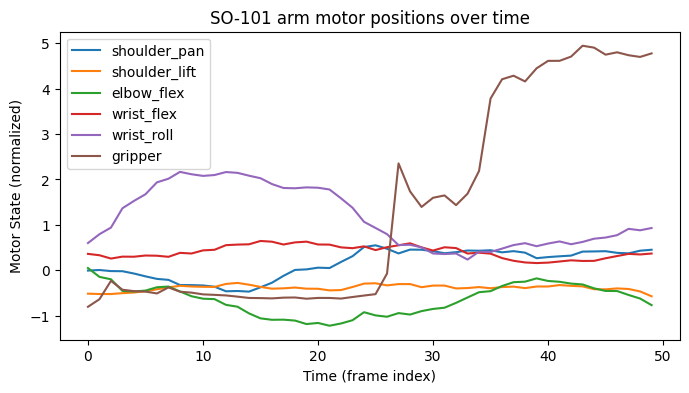

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(actions.squeeze()[:,:6].to('cpu'))
plt.title("SO-101 arm motor positions over time")
plt.xlabel("Time (frame index)")
plt.ylabel("Motor State (normalized)")
plt.legend(motor_labels, loc="best")
plt.show()

## Key Takeaways

Congratulations you've successfully ran your first VLA! Now you know:
- VLAs are the current state-of-the-art robot policies.
- We have built intuition on what is proprioception and what robot policy actions look like.
- You now know how to run cutting edge models like SmolVLA from Hugging Face on a Ryzen AI PC.

## Next Steps

- Try visualizing [different datasets](https://huggingface.co/lerobot/datasets) or episodes of the currently loaded data
- Explore the inference code for SmolVLA and try gauging performance by timing it
- Change the task string and see how the policy responds to different text instructions

The next workshop session will cover more advanced topics like training policies in digital twin environments.

---
Copyright© 2025 AMD, Inc. SPDX-License-Identifier: MIT